Within this notebook, we explore the application of DAG Convolutional Network (DC) to solve a source identification problem. The dataset is generated from an input signal predominantly zero across all nodes except for a single designated node. This input signal is then diffused across the DAG. Subsequently, our objective is to accurately discern the node responsible for originating the signals based on the output data.


In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import time
import dgl
import torch
from torch import nn
from torch.nn import functional as F
import networkx as nx

import src.dag_utils as dagu
import src.utils as utils
from src.arch import DAGConv, FB_DAGConv, SF_DAGConv
from src.models import SrcIdModel, LinDAGClassModel
from src.baselines_archs import MyGCNN, GAT, MLP, GraphSAGE, GIN

# Ser random seed
SEED = 10
PATH = 'results/src_id/'
SAVE = False
np.random.seed(SEED)
torch.manual_seed(SEED)
dgl.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Default parameters and auxiliary functions

In [2]:
M = 2000

data_p = {
    'n_tries': 25,

    ## Graph parameters
    'p': 0.2,                    # Edge prob in Erdos-Renyi DAG
    'N': 100,                    # Number of nodes

    ## Signal parameters
    'M': M,                   # Number of observed signals
    'M_train': int(0.7 * M),  # Samples selected for training
    'M_val': int(0.2 * M),    # Samples selected for validation
    'M_test': int(0.1 * M),   # Samples selected for test
    'src_t': 'random',          # 'random' or 'constant'
    'max_src_node': 20,  # 10           # Maximum index of nodes allowed to be sources
    'n_sources': 1,              # Maximum Number of source nodes
    'n_p_y': .05,  
    'n_p_x': 0,                  # Normalized noise power
    'max_GSO': 100,              # Maximum index of GSOs involved in the diffusion
    'min_GSO': 50,               # Minimum index of GSOs involved in the diffusion
    'n_GSOs': 25                 # Number of GSOs
}

# Model parameters
default_arch_p = {
    'in_dim': 1,        # Input dimension
    'hid_dim': 32,     # Hidden dimension
    'out_dim': 1,       # Output dimension
    'L': 2,  # 3 also works well          # Number of layers
    'l_act': None,
}

default_mod_p = {
    'bs': 25,           # Size of the batch
    'lr': 5e-3,         # Learning rate
    'epochs': 100,  # 50,       # Number of training epochs 
    'pat': 25,  # 15,          # Number of non-decreasing epoch to stop training
    'wd': 1e-4,         # Weight decay
}

##########   AUXILIARY FUNCTIONS   ##########   
def get_signals(d_p, GSOs, get_srcs=False):
    range_GSO = np.arange(d_p['min_GSO'], d_p['max_GSO'])
    gsos_idx = np.random.choice(range_GSO, size=d_p['n_GSOs'], replace=False)
    sel_GSOs = GSOs[gsos_idx]
    signals_t, srcs_t, _ = dagu.create_diff_data(d_p['M'], sel_GSOs, d_p['max_src_node'], d_p['n_p_x'],
                                                 d_p['n_p_y'], d_p['n_sources'], src_t=d_p['src_t'],
                                                 torch_tensor=True, mask_sources=True)
    labels_t = torch.argmax(torch.abs(srcs_t), axis=1)

    signals = {'train': signals_t[:d_p['M_train']], 'val': signals_t[d_p['M_train']:-d_p['M_test']],
                 'test': signals_t[-d_p['M_test']:]}
    labels = {'train': labels_t[:d_p['M_train']], 'val': labels_t[d_p['M_train']:-d_p['M_test']],
              'test': labels_t[-d_p['M_test']:]}
    
    if get_srcs:
        srcs = {'train': srcs_t[:d_p['M_train']], 'val': srcs_t[d_p['M_train']:-d_p['M_test']],
              'test': srcs_t[-d_p['M_test']:]}
        
        return signals, labels, sel_GSOs, srcs
    
    return signals, labels, sel_GSOs


def run_exp(d_p, d_arc_p, d_mod_p, exps):
    acc = np.zeros((d_p['n_tries'], len(exps)))
    times = np.zeros((d_p['n_tries'], len(exps)))

    t_begin = time.time()
    for i in range(d_p['n_tries']):
        Adj, W, GSOs, Psi = utils.get_graph_data(d_p, get_Psi=True)
        signals, labels, sel_GSOs, srcs = get_signals(d_p, GSOs, get_srcs=True)

        for j, exp in enumerate(exps):
            arc_p = {**d_arc_p, **exp['arc_p']} if 'arc_p' in exp else d_arc_p
            mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp else d_mod_p

            if arc_p['arch'] == LinDAGClassModel:
                if 'transp' in arc_p.keys() and arc_p['transp']:
                    dag_T = nx.from_numpy_array(Adj, create_using=nx.DiGraph())
                    Psi = np.array([dagu.compute_Dq(dag_T, i, d_p['N']) for i in range(d_p['N'])]).T
                    arc_p['transp'] = False

                Psi_sel = utils.select_GSO(arc_p, Psi.T, None, W, Adj).numpy().T
                lin_model = LinDAGClassModel(W, Psi_sel)
                t_i = time.time()
                # lin_model.fit(signals['train'], labels['train'])
                lin_model.fit(signals['train'], srcs['train'])
                t_e = time.time() - t_i

                acc[i,j] = lin_model.test(signals['test'], labels['test'])
            
            else:
                GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)
                K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0 
                arch = utils.instantiate_arch(arc_p, K)
                model = SrcIdModel(arch, device=device)

                t_i = time.time()
                model.fit(signals, labels, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                        patience=mod_p['pat'])
                t_e = time.time() - t_i

                acc[i,j] = model.test(signals['test'], labels['test'], GSO)
            times[i,j] = t_e

            print(f'-{i}. {exp["leg"]}: acc: {acc[i,j]:.3f} - time: {times[i,j]:.1f}')
    
    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times


def run_exps(exps, d_arc_p, d_mod_p, d_dat_p, GSOs, W, Adj, exp_desc='default'):
    acc_exps = np.zeros(len(exps))
    times_exps = np.zeros(len(exps))
    
    signals, labels, sel_GSOs = get_signals(d_dat_p, GSOs)
    
    for k, exp in enumerate(exps):
        arc_p = {**d_arc_p, **exp['arc_p']}
        mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp else d_mod_p

        GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)
        K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0 
        arch = utils.instantiate_arch(arc_p, K)
        model = SrcIdModel(arch, device=device)
        
        t_i = time.time()
        model.fit(signals, labels, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                  patience=mod_p['pat'])
        t_e = time.time() - t_i
        
        acc_exps[k] = model.test(signals['test'], labels['test'], GSO)
        times_exps[k] = t_e

        print(f'\t-{exp_desc}. {exp["leg"]}: acc: {acc_exps[k]:.3f} - time: {times_exps[k]:.1f}')

    return acc_exps, times_exps

## Initial Test - As classification problem

In [3]:
mod_p_init = default_mod_p.copy()
mod_p_init['pat'] = 100

Exps = [
    # My Model
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'DCN'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'DCN-30'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'DCN-10'},

    # My Model - Transposed
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True}, 'leg': 'DCN-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'DCN-30-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'DCN-10-T'},

    # Linear baselines
    {'arc_p': {'arch': LinDAGClassModel, 'GSO': 'GSOs'}, 'leg': 'Linear'},
    {'arc_p': {'arch': LinDAGClassModel, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'Linear-30'},
    {'arc_p': {'arch': LinDAGClassModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'Linear-10'},
    {'arc_p': {'arch': LinDAGClassModel, 'GSO': 'GSOs', 'transp': True}, 'leg': 'Linear-T'},
    {'arc_p': {'arch': LinDAGClassModel, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'Linear-30-T'},
    {'arc_p': {'arch': LinDAGClassModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'Linear-10-T'},

    # GNN Baselines
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': True}, 'leg': 'FB-GCNN-2'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': True}, 'leg': 'FB-GCNN-3'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': True}, 'leg': 'FB-GCNN-4'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'transp': True, 'n_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}},
     'leg': 'GAT'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'transp': True, 'hid_dim': 16, 'agg': 'mean'}, 'leg': 'GraphSAGE-A'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'transp': True, 'hid_dim': 16, 'agg': 'sum'}, 'leg': 'GIN-A'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'mod_p': {}, 'leg': 'MLP'},    
    ]

acc, times = run_exp(data_p, default_arch_p, mod_p_init, Exps)

-0. DCN: acc: 0.045 - time: 8.4
-0. DCN-30: acc: 0.075 - time: 7.4
-0. DCN-10: acc: 0.020 - time: 7.1
-0. DCN-T: acc: 0.985 - time: 8.6
-0. DCN-30-T: acc: 0.985 - time: 8.0
-0. DCN-10-T: acc: 0.655 - time: 8.0
-0. Linear: acc: 0.060 - time: 0.4
-0. Linear-30: acc: 0.060 - time: 0.2
-0. Linear-10: acc: 0.060 - time: 0.2
-0. Linear-T: acc: 0.060 - time: 0.4
-0. Linear-30-T: acc: 0.060 - time: 0.2
-0. Linear-10-T: acc: 0.060 - time: 0.2
-0. FB-GCNN-2: acc: 0.525 - time: 7.6
-0. FB-GCNN-3: acc: 0.700 - time: 7.9
-0. FB-GCNN-4: acc: 0.715 - time: 7.9
-0. GNN-A: acc: 0.070 - time: 7.5
-0. GAT: acc: 0.000 - time: 28.7
-0. GraphSAGE-A: acc: 0.565 - time: 12.3
-0. GIN-A: acc: 0.110 - time: 12.3
-0. MLP: acc: 0.060 - time: 4.8
-1. DCN: acc: 0.035 - time: 7.7
-1. DCN-30: acc: 0.065 - time: 7.7
-1. DCN-10: acc: 0.030 - time: 7.6
-1. DCN-T: acc: 1.000 - time: 8.7
-1. DCN-30-T: acc: 1.000 - time: 8.3
-1. DCN-10-T: acc: 1.000 - time: 8.1
-1. Linear: acc: 0.030 - time: 0.4
-1. Linear-30: acc: 0.030 - 

In [4]:
# No noise
if SAVE:
    file_name = PATH + f'init_exp'
    np.savez(file_name, acc=acc, times=times, exp=Exps)
    print('SAVED FILE:', file_name)  

leg = [exp['leg'] for exp in Exps]
utils.display_data(leg, acc, np.std(acc, axis=0), times, metric_label='Acc')

,Exp,Mean Acc,Median Acc,Mean Std,time
0,DCN,0.0478,0.045,0.016738,7.623375
1,DCN-30,0.0476,0.050,0.016194,7.195844
2,DCN-10,0.0442,0.045,0.016042,7.232288
3,DCN-T,0.9874,1.000,0.032160,8.299962
4,DCN-30-T,0.9802,0.995,0.042225,7.784564
5,DCN-10-T,0.8408,0.865,0.144677,7.653033
6,Linear,0.0510,0.050,0.016062,0.377774
7,Linear-30,0.0510,0.050,0.016062,0.190988
8,Linear-10,0.0510,0.050,0.016062,0.161920
9,Linear-T,0.0510,0.050,0.016062,0.369947


In [5]:
# file_name = PATH + 'init_exp.npz'
# acc, times, Exps, _ = utils.load_data(file_name, src_id=True)

## Influence of the number of source nodes

In [6]:
def influence_sources_exp(d_dat_p, d_arc_p, d_mod_p, Max_sources, exps):
    acc = np.zeros((d_dat_p['n_tries'], len(Max_sources), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(Max_sources), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        Adj, W, GSOs = utils.get_graph_data(d_dat_p)

        for j, max_srcs in enumerate(Max_sources):
            data_params_aux = dict(d_dat_p)
            data_params_aux['max_src_node'] = max_srcs
            acc[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                            Adj, exp_desc=str(max_srcs))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times

In [7]:
Max_sources = np.arange(10, 91, 10)

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True},'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'DCN-30',
     'fmt': 's-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20, 'transp': True}, 'leg': 'DCN-20',
     'fmt': 's--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'DCN-10',
     'fmt': 's:'},

    # Baselines
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': True}, 'leg': 'FB-GCNN-3', 'fmt': '2:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'transp': True, 'n_heads': 2, 'hid_dim': 16,'gat_params': {'attn_drop': 0}},
      'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean', 'transp': True,},
     'leg': 'GraphSAGE-A', 'fmt': '<:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum', 'transp': True}, 'leg': 'GIN-A', 'fmt': '>:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP', 'fmt': '1:'},
    ]

acc, times = influence_sources_exp(data_p, default_arch_p, default_mod_p, Max_sources, Exps)


Iteration: 0
	-10. DCN: acc: 1.000 - time: 3.9
	-10. DCN-30: acc: 1.000 - time: 7.1
	-10. DCN-20: acc: 0.995 - time: 7.7
	-10. DCN-10: acc: 0.995 - time: 7.1
	-10. FB-GCNN-3: acc: 0.945 - time: 7.7
	-10. GNN-A: acc: 0.120 - time: 2.1
	-10. GAT-A: acc: 0.005 - time: 28.9
	-10. GraphSAGE-A: acc: 0.920 - time: 12.6
	-10. GIN-A: acc: 0.270 - time: 12.5
	-10. MLP: acc: 0.090 - time: 4.8
	-20. DCN: acc: 1.000 - time: 4.0
	-20. DCN-30: acc: 1.000 - time: 6.7
	-20. DCN-20: acc: 1.000 - time: 7.3
	-20. DCN-10: acc: 0.940 - time: 7.2
	-20. FB-GCNN-3: acc: 0.860 - time: 6.9
	-20. GNN-A: acc: 0.040 - time: 1.9
	-20. GAT-A: acc: 0.000 - time: 10.5
	-20. GraphSAGE-A: acc: 0.735 - time: 11.1
	-20. GIN-A: acc: 0.140 - time: 10.2
	-20. MLP: acc: 0.040 - time: 4.6
	-30. DCN: acc: 1.000 - time: 8.2
	-30. DCN-30: acc: 1.000 - time: 6.4
	-30. DCN-20: acc: 1.000 - time: 7.6
	-30. DCN-10: acc: 1.000 - time: 7.5
	-30. FB-GCNN-3: acc: 0.935 - time: 7.7
	-30. GNN-A: acc: 0.525 - time: 4.3
	-30. GAT-A: acc: 0.40

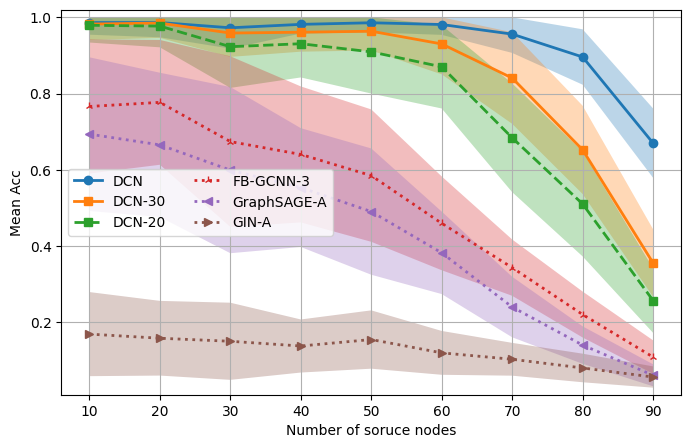

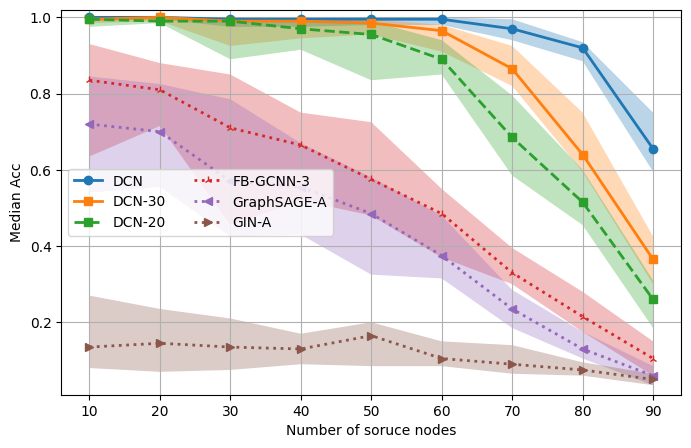

In [8]:
mean_acc = acc.mean(axis=0)
med_acc = np.median(acc, axis=0)
std_acc = acc.std(axis=0)
prctile25_acc = np.percentile(acc, 25, axis=0)
prctile75_acc = np.percentile(acc, 75, axis=0)

if SAVE:
    # Save np files
    file_name = PATH + f'src_nodes/src_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=Max_sources)
    print('SAVED FILE:', file_name)

    # Save csv files for pgfplot
    file_name_data = f'{file_name}-mean_acc.csv'
    utils.data_to_csv(file_name_data, Exps, Max_sources, mean_acc)
    file_name_data = f'{file_name}-std_up_acc.csv'
    utils.data_to_csv(file_name_data, Exps, Max_sources, mean_acc + std_acc)
    file_name_data = f'{file_name}-std_down_acc.csv'
    utils.data_to_csv(file_name_data, Exps, Max_sources, mean_acc - std_acc)
    # file_name_data = f'{file_name}-mean_acc.csv'
    # utils.data_to_csv(file_name_data, Exps, Max_sources, mean_acc)
    # file_name_data = f'{file_name}-std_acc.csv'
    # utils.data_to_csv(file_name_data, Exps, Max_sources, std_acc)
    file_name_data = f'{file_name}-med_acc.csv'
    utils.data_to_csv(file_name_data, Exps, Max_sources, med_acc)
    file_name_data = f'{file_name}-prct75_acc.csv'
    utils.data_to_csv(file_name_data, Exps, Max_sources, prctile75_acc)
    file_name_data = f'{file_name}-prct25_acc.csv'
    utils.data_to_csv(file_name_data, Exps, Max_sources, prctile25_acc)

legend = [exp['leg'] for exp in Exps]
skip = [3, 5, 6, 9] #[4, 5, 8]
utils.plot_results(mean_acc, Max_sources, Exps, 'Number of soruce nodes', logy=False, std=std_acc,
                   ylabel='Mean Acc', n_cols=2, ylim_top=1.02, skip_idx=skip)

utils.plot_results(med_acc, Max_sources, Exps, 'Number of soruce nodes', logy=False, n_cols=2, 
                   ylabel='Median Acc', prctile_up=prctile75_acc, prctile_low=prctile25_acc,
                   ylim_top=1.02, skip_idx=skip)


In [9]:
# file_name = PATH + 'src_nodes/src_nodes_inf-random.npz'
# acc, times, Exps, Max_sources = utils.load_data(file_name, src_id=True)

## Influence of te graph density

In [10]:
def influence_graph_density(d_dat_p, d_arc_p, d_mod_p, P_values, exps):
    acc = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        for j, p in enumerate(P_values):
            data_params_aux = dict(d_dat_p)
            data_params_aux['p'] = p
            Adj, W, GSOs = utils.get_graph_data(data_params_aux)

            acc[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                            Adj, exp_desc=str(p))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times

In [11]:
P_values = np.array([.1, .2, .3, .4, .5, .6, .7])

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True},'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20, 'transp': True}, 'leg': 'DCN-20',
     'fmt': 'P--'}, 

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': True}, 'leg': 'FB-GCNN-2', 'fmt': '2-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': True}, 'leg': 'FB-GCNN-3', 'fmt': '2--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': True}, 'leg': 'FB-GCNN-4', 'fmt': '2-.'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 5, 'transp': True}, 'leg': 'FB-GCNN-5', 'fmt': '2-.'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 6, 'transp': True}, 'leg': 'FB-GCNN-6', 'fmt': '2:'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 7, 'transp': True}, 'leg': 'FB-GCNN-7', 'fmt': '2:'},
    
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean', 'transp': True,},
     'leg': 'GraphSAGE-A',  'fmt': '<:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum', 'transp': True}, 'leg': 'GIN-A',
      'fmt': '>:'},
    ]

acc, times = influence_graph_density(data_p, default_arch_p, default_mod_p, P_values, Exps)


Iteration: 0
	-0.1. DCN: acc: 1.000 - time: 6.6
	-0.1. DCN-20: acc: 0.995 - time: 8.0
	-0.1. FB-GCNN-2: acc: 0.690 - time: 7.8
	-0.1. FB-GCNN-3: acc: 0.810 - time: 7.9
	-0.1. FB-GCNN-4: acc: 0.840 - time: 8.0
	-0.1. FB-GCNN-5: acc: 0.820 - time: 6.9
	-0.1. FB-GCNN-6: acc: 0.935 - time: 6.9
	-0.1. FB-GCNN-7: acc: 0.925 - time: 7.9
	-0.1. GNN-A: acc: 0.045 - time: 1.9
	-0.1. GraphSAGE-A: acc: 0.850 - time: 12.5
	-0.1. GIN-A: acc: 0.410 - time: 12.9
	-0.2. DCN: acc: 0.990 - time: 6.0
	-0.2. DCN-20: acc: 0.960 - time: 7.8
	-0.2. FB-GCNN-2: acc: 0.535 - time: 7.6
	-0.2. FB-GCNN-3: acc: 0.705 - time: 7.8
	-0.2. FB-GCNN-4: acc: 0.740 - time: 8.0
	-0.2. FB-GCNN-5: acc: 0.735 - time: 8.2
	-0.2. FB-GCNN-6: acc: 0.710 - time: 8.2
	-0.2. FB-GCNN-7: acc: 0.780 - time: 7.3
	-0.2. GNN-A: acc: 0.055 - time: 2.2
	-0.2. GraphSAGE-A: acc: 0.540 - time: 12.6
	-0.2. GIN-A: acc: 0.115 - time: 12.4
	-0.3. DCN: acc: 0.710 - time: 8.4
	-0.3. DCN-20: acc: 0.515 - time: 6.6
	-0.3. FB-GCNN-2: acc: 0.160 - time: 7

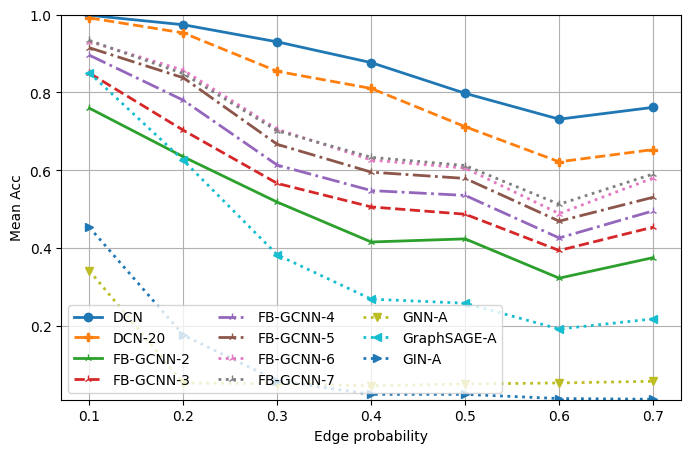

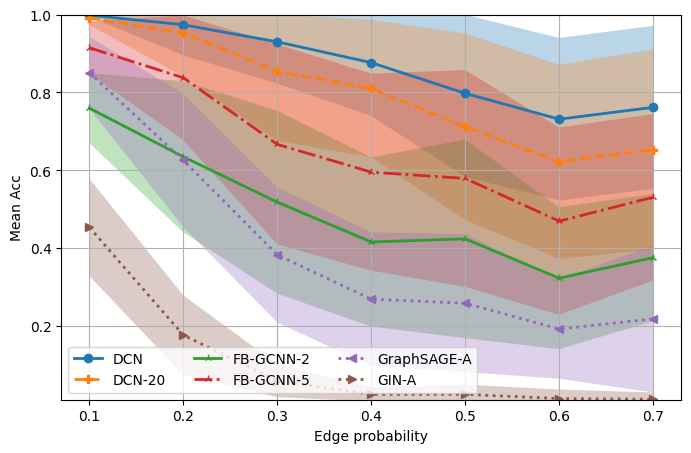

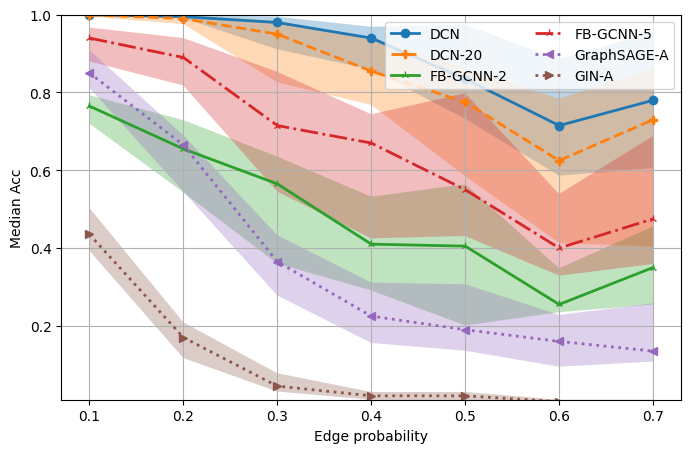

In [12]:
mean_acc = acc.mean(axis=0)
std_acc = acc.std(axis=0)
med_acc = np.median(acc, axis=0)
prctile25_acc = np.percentile(acc, 30, axis=0)
prctile75_acc = np.percentile(acc, 70, axis=0)

if SAVE:
    # Save numpy data
    file_name = PATH + f'density/density_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=P_values)
    print('SAVED FILE:', file_name)

    # Save csv files for pgfplot
    file_name_data = f'{file_name}-mean_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, mean_acc)
    file_name_data = f'{file_name}-std_up_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, mean_acc + std_acc)
    file_name_data = f'{file_name}-std_down_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, mean_acc - std_acc)
    file_name_data = f'{file_name}-med_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, med_acc)
    file_name_data = f'{file_name}-prct75_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, prctile75_acc)
    file_name_data = f'{file_name}-prct25_acc.csv'
    utils.data_to_csv(file_name_data, Exps, P_values, prctile25_acc)

legend = [exp['leg'] for exp in Exps]

# Plot mean + std
skip = []
utils.plot_results(mean_acc, P_values, Exps, 'Edge probability', logy=False, skip_idx=skip,
                   ylabel='Mean Acc', n_cols=3, std=None)

skip = [3, 4, 6, 7, 8]
utils.plot_results(mean_acc, P_values, Exps, 'Edge probability', logy=False, skip_idx=skip,
                   ylabel='Mean Acc', n_cols=3, std=std_acc)

# skip = []  # [1, 3, 5, 7, 10]
utils.plot_results(med_acc, P_values, Exps, 'Edge probability', logy=False, skip_idx=skip, n_cols=2,
                   ylabel='Median Acc', prctile_up=prctile75_acc, prctile_low=prctile25_acc)

In [13]:
# file_name = PATH + 'density/density_inf-random.npz'
# acc, times, Exps, P_values = utils.load_data(file_name, src_id=True)

## Additional experiments

### Varying the size of the graph

In [21]:
def influence_graph_size(d_dat_p, d_arc_p, d_mod_p, N_nodes, exps):
    acc = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        for j, n_nodes in enumerate(N_nodes):
            data_params_aux = dict(d_dat_p)
            data_params_aux['N'] = n_nodes
            # Always use second half of nodes to generate data
            data_params_aux['max_GSO'] = n_nodes
            data_params_aux['min_GSO'] = int(n_nodes/2)
            available_nodes = data_params_aux['max_GSO'] - data_params_aux['min_GSO']
            #data_params_aux['n_GSOs'] = min(d_dat_p['n_GSOs'], available_nodes)
            data_params_aux['n_GSOs'] = int(available_nodes/2)
            
            Adj, W, GSOs = utils.get_graph_data(data_params_aux)

            acc[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                            Adj, exp_desc=str(Adj.shape[0]))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times

In [22]:
N_nodes = [25, 50, 100, 200, 400]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True},'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 25, 'transp': True}, 'leg': 'DCN-25',
     'fmt': 'o--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'DCN-10',
     'fmt': 'o:'}, 


    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean', 'transp': True,},
     'leg': 'GraphSAGE-A',  'fmt': '<:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum', 'transp': True}, 'leg': 'GIN-A',
      'fmt': '>:'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': True}, 'leg': 'FB-GCNN-4', 'fmt': '^:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A-T', 'fmt': 'v:'},
    ]

acc, times = influence_graph_size(data_p, default_arch_p, default_mod_p, N_nodes, Exps)


Iteration: 0
	-25. DCN: acc: 0.560 - time: 7.9
	-25. DCN-25: acc: 0.570 - time: 7.3
	-25. DCN-10: acc: 0.415 - time: 7.9
	-25. GraphSAGE-A: acc: 0.205 - time: 12.4
	-25. GIN-A: acc: 0.410 - time: 12.5
	-25. FB-GCNN-4: acc: 0.280 - time: 7.7
	-25. GNN-A-T: acc: 0.055 - time: 7.1
	-50. DCN: acc: 1.000 - time: 6.7
	-50. DCN-25: acc: 0.980 - time: 8.0
	-50. DCN-10: acc: 0.935 - time: 7.7
	-50. GraphSAGE-A: acc: 0.665 - time: 12.3
	-50. GIN-A: acc: 0.415 - time: 12.1
	-50. FB-GCNN-4: acc: 0.845 - time: 7.5
	-50. GNN-A-T: acc: 0.040 - time: 6.1
	-100. DCN: acc: 0.955 - time: 7.9
	-100. DCN-25: acc: 0.930 - time: 8.0
	-100. DCN-10: acc: 0.530 - time: 7.6
	-100. GraphSAGE-A: acc: 0.295 - time: 12.6
	-100. GIN-A: acc: 0.165 - time: 8.6
	-100. FB-GCNN-4: acc: 0.480 - time: 7.5
	-100. GNN-A-T: acc: 0.070 - time: 2.1
	-200. DCN: acc: 1.000 - time: 32.7
	-200. DCN-25: acc: 0.995 - time: 8.0
	-200. DCN-10: acc: 0.975 - time: 8.2
	-200. GraphSAGE-A: acc: 0.855 - time: 12.4
	-200. GIN-A: acc: 0.045 - 

SAVED FILE: results/src_id/n_nodes_inf-random


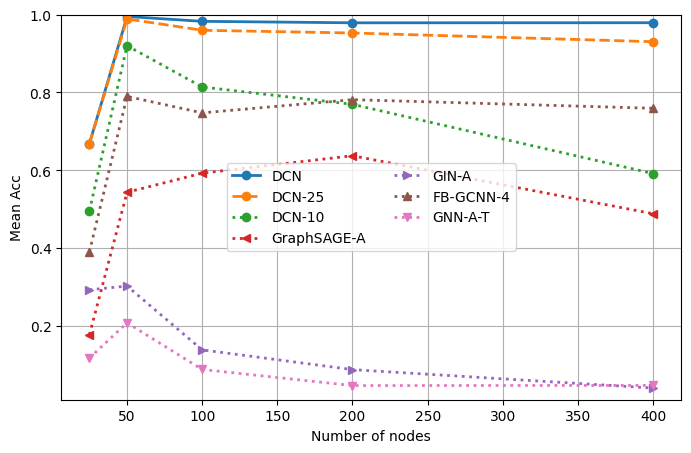

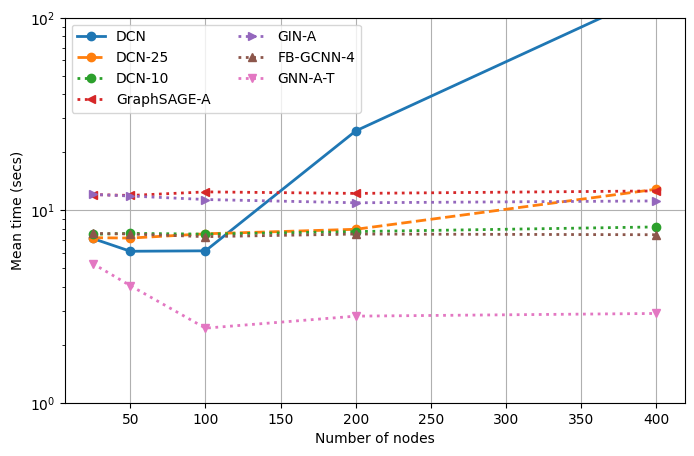

In [23]:
mean_acc = acc.mean(axis=0)
std_acc = acc.std(axis=0)
med_acc = np.median(acc, axis=0)
prctile25_acc = np.percentile(acc, 25, axis=0)
prctile75_acc = np.percentile(acc, 75, axis=0)

if True:
    file_name = PATH + f'n_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=N_nodes)
    print('SAVED FILE:', file_name)

mean_acc = acc.mean(axis=0)
mean_time = times.mean(axis=0)
med_acc = np.median(acc, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_acc, N_nodes, Exps, 'Number of nodes', logy=False, n_cols=2,
                   ylabel='Mean Acc')
utils.plot_results(mean_time, N_nodes, Exps, 'Number of nodes', logy=True, ylabel='Mean time (secs)',
                   ylim_bottom=1, ylim_top=100, n_cols=2)

In [24]:
# file_name = PATH + 'n_nodes_inf-random.npz'
# acc, times, Exps, N_nodes = utils.load_data(file_name, src_id=True)

### Noise influence

In [25]:
def influence_noise(d_dat_p, d_arc_p, d_mod_p, Noise_values, exps):
    acc = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        for j, noise in enumerate(Noise_values):
            data_params_aux = dict(d_dat_p)
            data_params_aux['n_p_y'] = noise
            
            Adj, W, GSOs = utils.get_graph_data(data_params_aux)

            acc[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                            Adj, exp_desc=str(Adj.shape[0]))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times

In [26]:
Noise_values = np.arange(0, .41, .05)

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True},'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'DCN-30',
     'fmt': 'o--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'DCN-10',
     'fmt': 'o:'}, 


    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean', 'transp': True,},
     'leg': 'GraphSAGE-A',  'fmt': '<:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum', 'transp': True}, 'leg': 'GIN-A',
      'fmt': '>:'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': True}, 'leg': 'FB-GCNN-4', 'fmt': '^:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A-T', 'fmt': 'v:'},
    ]

acc, times = influence_noise(data_p, default_arch_p, default_mod_p, Noise_values, Exps)


Iteration: 0
	-100. DCN: acc: 1.000 - time: 8.3
	-100. DCN-30: acc: 1.000 - time: 8.0
	-100. DCN-10: acc: 1.000 - time: 7.7
	-100. GraphSAGE-A: acc: 0.865 - time: 12.7
	-100. GIN-A: acc: 0.340 - time: 12.6
	-100. FB-GCNN-4: acc: 1.000 - time: 7.6
	-100. GNN-A-T: acc: 0.050 - time: 1.9
	-100. DCN: acc: 1.000 - time: 8.2
	-100. DCN-30: acc: 0.995 - time: 7.5
	-100. DCN-10: acc: 0.960 - time: 7.7
	-100. GraphSAGE-A: acc: 0.820 - time: 12.5
	-100. GIN-A: acc: 0.140 - time: 12.6
	-100. FB-GCNN-4: acc: 0.820 - time: 7.6
	-100. GNN-A-T: acc: 0.040 - time: 2.0
	-100. DCN: acc: 0.960 - time: 8.1
	-100. DCN-30: acc: 0.925 - time: 8.1
	-100. DCN-10: acc: 0.905 - time: 7.5
	-100. GraphSAGE-A: acc: 0.645 - time: 12.7
	-100. GIN-A: acc: 0.050 - time: 12.5
	-100. FB-GCNN-4: acc: 0.705 - time: 7.6
	-100. GNN-A-T: acc: 0.045 - time: 1.9
	-100. DCN: acc: 0.960 - time: 5.8
	-100. DCN-30: acc: 0.950 - time: 7.8
	-100. DCN-10: acc: 0.835 - time: 7.5
	-100. GraphSAGE-A: acc: 0.400 - time: 12.6
	-100. GIN-A:

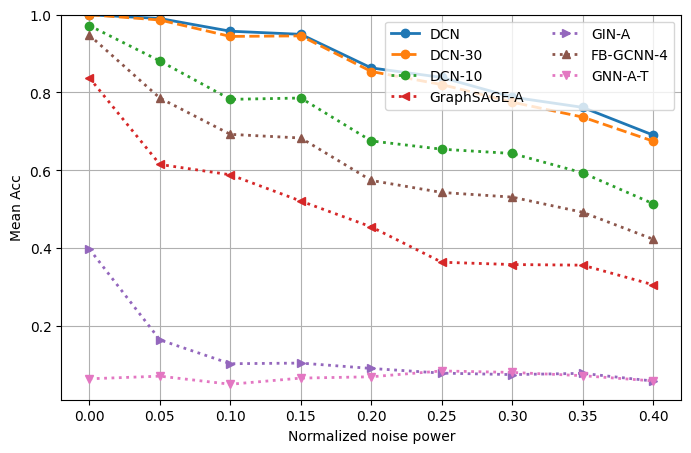

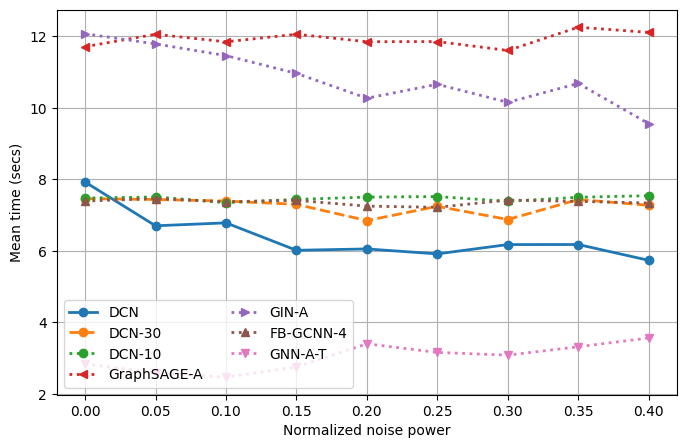

In [27]:
if SAVE:
    file_name = PATH + f'noise_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=Noise_values)
    print('SAVED FILE:', file_name)

mean_acc = acc.mean(axis=0)
mean_time = times.mean(axis=0)
med_acc = np.median(acc, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_acc, Noise_values, Exps, 'Normalized noise power', ylabel='Mean Acc',
                   logy=False, n_cols=2)
utils.plot_results(mean_time, Noise_values, Exps, 'Normalized noise power', logy=False, ylabel='Mean time (secs)',
                   ylim_bottom=None, ylim_top=None, n_cols=2)


In [28]:
# file_name = PATH + 'noise_inf-random.npz'
# acc, times, Exps, Noise_values = utils.load_data(file_name, src_id=True)